In [1]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from PIL import Image


file = 't10k-images-idx3-ubyte'
arr = idx2numpy.convert_from_file(file)
'''
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(arr[i], cmap=plt.get_cmap('gray'))
    plt.show()
    '''
print(np.shape(arr[4]))

def vertical_half(image):
    h,w = image.shape
    w_cutoff = w // 2
    s1 = image[:,:w_cutoff]
    s2 = image[:,w_cutoff:]
    return s1, s2

half_images = []
for i in range(len(arr)):
    img1,img2 = vertical_half(arr[i])
    half_images.append(img1)
    half_images.append(img2)
    #plt.figure()
    #plt.subplot(121)
    #plt.imshow(img1)
    #plt.subplot(122)
    #plt.imshow(img2)
    #plt.subplot(121)
    #plt.imshow(half_images[i])
    #plt.subplot(122)
    #plt.imshow(half_images[i+1])


half_imarr = np.asarray(half_images)




(28, 28)


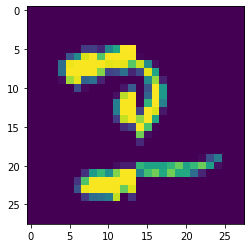

In [2]:
plt.imshow(restore(half_imarr[1000], half_imarr[5001]))

In [3]:
import torch
from PIL import Image
import os
from tqdm import tqdm
from torch.utils.data import Dataset

import torchvision.transforms as T
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [4]:
class MnisthalfDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]

        if self.transform is not None:
            tensor_image = self.transform(image)

        return tensor_image


In [5]:
class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.img_size = img_size
        self.conv1 = nn.Conv2d(1, 28, (3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(28, 56, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(56, 112, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))

    def forward(self, x):
        # Downscale the image with conv maxpool etc.
        #print(x.shape)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        #print(x.shape)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        #print(x.shape)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        #print(x.shape)
        return x
    
class ConvDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(112, 56, (3, 3), stride=(2, 2))
        # self.upsamp1 = nn.UpsamplingBilinear2d(2)
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(56, 28, (2, 3), stride=(2, 2))
#         self.upsamp1 = nn.UpsamplingBilinear2d(2)
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(28, 1, (2, 2), stride=(2, 2))
        #self.upsamp1 = nn.UpsamplingBilinear2d(2)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        #print(x.shape)
        x = self.deconv1(x)
        x = self.relu1(x)
        #print(x.shape)

        x = self.deconv2(x)
        x = self.relu2(x)
        #print(x.shape)

        x = self.deconv3(x)
        x = self.relu3(x)
        #print(x.shape)
        return x

In [24]:
IMG_HEIGHT = 28  # The images are already resized here
IMG_WIDTH = 14  # The images are already resized here

SEED = 42
TRAIN_RATIO = 0.75
VAL_RATIO = 1 - TRAIN_RATIO
SHUFFLE_BUFFER_SIZE = 100

LEARNING_RATE = 1e-3
EPOCHS = 10
TRAIN_BATCH_SIZE = 32  # Let's see, I don't have GPU, Google Colab is best hope
TEST_BATCH_SIZE = 32  # Let's see, I don't have GPU, Google Colab is best hope
FULL_BATCH_SIZE = 32

AUTOENCODER_MODEL_PATH = "baseline_autoencoder.pt"
ENCODER_MODEL_PATH = "baseline_encoder.pt"
DECODER_MODEL_PATH = "baseline_decoder.pt"


In [25]:
__all__ = ["train_step", "val_step", "create_embedding"]

import torch
import torch.nn as nn

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_step(encoder, decoder, train_loader, loss_fn, optimizer, device):
    # device = "cuda"
    encoder.train()
    decoder.train()

    # print(device)

    for batch_idx, train_img in enumerate(train_loader):
        train_img = train_img.to(device)
        #target_img = target_img.to(device)
        #print(train_img.shape)
        optimizer.zero_grad()

        enc_output = encoder(train_img)
        #print('encoder',enc_output.shape)
        dec_output = decoder(enc_output)
        #print('decoder',dec_output.shape)
        
        loss = loss_fn(train_img, dec_output)
        loss.backward()

        optimizer.step()

    return loss.item()

def val_step(encoder, decoder, val_loader, loss_fn, device):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for batch_idx, train_img in enumerate(val_loader):
            train_img = train_img.to(device)
            #target_img = target_img.to(device)

            enc_output = encoder(train_img)
            dec_output = decoder(enc_output)

            loss = loss_fn(train_img,dec_output)

    return loss.item()

In [26]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


transforms = T.Compose([
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,))
        ])
print("------------ Creating Dataset ------------")
full_dataset = MnisthalfDataset(half_imarr, transforms)

train_size = int(TRAIN_RATIO * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

print("------------ Dataset Created ------------")
print("------------ Creating DataLoader ------------")
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE)

full_loader = torch.utils.data.DataLoader(
    full_dataset, batch_size=FULL_BATCH_SIZE)

------------ Creating Dataset ------------
------------ Dataset Created ------------
------------ Creating DataLoader ------------


In [27]:
print("------------ Dataloader Cretead ------------")

# print(train_loader)
loss_fn = nn.MSELoss()

encoder = ConvEncoder()

decoder = ConvDecoder()

if torch.cuda.is_available():
    print("GPU Availaible moving models to GPU")
else:
    print("Moving models to CPU")

encoder.to(device)
decoder.to(device)

# print(device)

autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.AdamW(autoencoder_params, lr=LEARNING_RATE)

# early_stopper = utils.EarlyStopping(patience=5, verbose=True, path=)
max_loss = 9999

print("------------ Training started ------------")

for epoch in tqdm(range(EPOCHS)):
    train_loss = train_step(
        encoder, decoder, train_loader, loss_fn, optimizer, device=device
    )
    print(f"Epochs = {epoch}, Training Loss : {train_loss}")
    val_loss = val_step(
        encoder, decoder, val_loader, loss_fn, device=device
    )

    # Simple Best Model saving
    if val_loss < max_loss:
        print("Validation Loss decreased, saving new best model")
        torch.save(encoder.state_dict(), ENCODER_MODEL_PATH)
        torch.save(decoder.state_dict(), DECODER_MODEL_PATH)

    print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

print("Training Done")

  0%|          | 0/10 [00:00<?, ?it/s]

------------ Dataloader Cretead ------------
Moving models to CPU
------------ Training started ------------
Epochs = 0, Training Loss : 0.9239951372146606


 10%|█         | 1/10 [00:18<02:44, 18.28s/it]

Validation Loss decreased, saving new best model
Epochs = 0, Validation Loss : 0.9251199960708618
Epochs = 1, Training Loss : 0.9230300784111023


 20%|██        | 2/10 [00:36<02:24, 18.04s/it]

Validation Loss decreased, saving new best model
Epochs = 1, Validation Loss : 0.9251199960708618
Epochs = 2, Training Loss : 0.9280116558074951


 30%|███       | 3/10 [00:54<02:05, 18.00s/it]

Validation Loss decreased, saving new best model
Epochs = 2, Validation Loss : 0.9251199960708618
Epochs = 3, Training Loss : 0.9266093969345093


 40%|████      | 4/10 [01:12<01:48, 18.04s/it]

Validation Loss decreased, saving new best model
Epochs = 3, Validation Loss : 0.9251199960708618
Epochs = 4, Training Loss : 0.9313117861747742


 50%|█████     | 5/10 [01:30<01:31, 18.22s/it]

Validation Loss decreased, saving new best model
Epochs = 4, Validation Loss : 0.9251199960708618
Epochs = 5, Training Loss : 0.9160170555114746


 60%|██████    | 6/10 [01:48<01:12, 18.14s/it]

Validation Loss decreased, saving new best model
Epochs = 5, Validation Loss : 0.9251199960708618
Epochs = 6, Training Loss : 0.9283717274665833


 70%|███████   | 7/10 [02:06<00:54, 18.09s/it]

Validation Loss decreased, saving new best model
Epochs = 6, Validation Loss : 0.9251199960708618
Epochs = 7, Training Loss : 0.9300898313522339


 80%|████████  | 8/10 [02:24<00:36, 18.06s/it]

Validation Loss decreased, saving new best model
Epochs = 7, Validation Loss : 0.9251199960708618
Epochs = 8, Training Loss : 0.9214169383049011


 90%|█████████ | 9/10 [02:42<00:18, 18.03s/it]

Validation Loss decreased, saving new best model
Epochs = 8, Validation Loss : 0.9251199960708618
Epochs = 9, Training Loss : 0.9186469912528992


100%|██████████| 10/10 [03:00<00:00, 18.06s/it]

Validation Loss decreased, saving new best model
Epochs = 9, Validation Loss : 0.9251199960708618
Training Done


In [28]:
def create_embedding(encoder, full_loader, embedding_dim, device):
    """
    Creates embedding using encoder from dataloader.
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    full_loader: PyTorch dataloader, containing (images, images) over entire dataset.
    embedding_dim: Tuple (c, h, w) Dimension of embedding = output of encoder dimesntions.
    device: "cuda" or "cpu"
    Returns: Embedding of size (num_images_in_loader + 1, c, h, w)
    """
    # Set encoder to eval mode.
    encoder.eval()
    # Just a place holder for our 0th image embedding.
    embedding = torch.randn(embedding_dim)
    
    # Again we do not compute loss here so. No gradients.
    with torch.no_grad():
        for batch_idx, train_img in enumerate(full_loader):
            # We can compute this on GPU. be faster
            train_img = train_img.to(device)
            
            # Get encoder outputs and move outputs to cpu
            enc_output = encoder(train_img).cpu()
            #print(enc_output.shape)
            # Keep adding these outputs to embeddings.
            embedding = torch.cat((embedding, enc_output), 0)
    
    # Return the embeddings
    return embedding

In [29]:
EMBEDDING_SHAPE = (32,112,3,1)
# We need feature representations for complete dataset not just train and validation.
# Hence we use full loader here.
embedding = create_embedding(encoder, full_loader, EMBEDDING_SHAPE, device)

# Convert embedding to numpy and save them
numpy_embedding = embedding.cpu().detach().numpy()
num_images = numpy_embedding.shape[0]

# Save the embeddings for complete dataset, not just train
flattened_embedding = numpy_embedding.reshape((num_images, -1))
np.save("data_embedding.npy", flattened_embedding)

In [30]:
def compute_similar_images(image, num_images, embedding, device):
    """
    Given an image and number of similar images to search.
    Returns the num_images closest neares images.
    Args:
    image: Image whose similar images are to be found.
    num_images: Number of similar images to find.
    embedding : A (num_images, embedding_dim) Embedding of images learnt from auto-encoder.
    device : "cuda" or "cpu" device.
    """
    
    image_tensor = T.ToTensor()(image)
    image_tensor = image_tensor.unsqueeze(0)
    
    with torch.no_grad():
        image_embedding = encoder(image_tensor).cpu().detach().numpy()
        
    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))

    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)

    _, indices = knn.kneighbors(flattened_embedding)
    indices_list = indices.tolist()
    return indices_list

In [31]:
def plot_similar_images(test,indices_list):
    plt.figure()
    plt.imshow(test)
    plt.show()
    indices = indices_list[0]
    for index in indices:
        img = half_imarr[index-1]
        print(index)
        plt.imshow(img)
        plt.show()

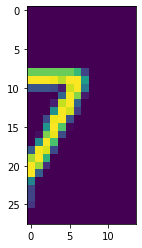

15775


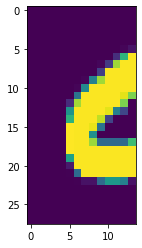

1761


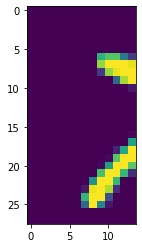

15859


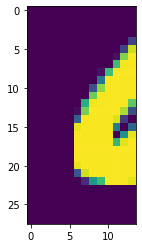

17973


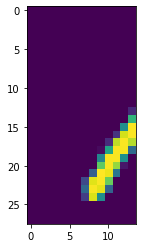

In [32]:
from sklearn.neighbors import NearestNeighbors

embedding = np.load('data_embedding.npy')

test = half_imarr[1]
indices_list = compute_similar_images(test, 4, embedding, device)


plot_similar_images(test,indices_list)

In [33]:
def restore(im1, im2):
    h1,w1 = im1.shape
    h2,w2 = im2.shape
    img = np.zeros((28,28),dtype=np.uint8)
    img[:,:w1] = im1 
    img[:,w1:] = im2
    #dst = Image.new('L',(w1 + w2, h2))
    return img
